# IterativeEikonal
Approximate the viscosity solution of the  Eikonal equation 
$$\begin{cases} \Vert \nabla_G W(g) \Vert = 1, & g \in G, \\
W(g) = 0, & g \in S \subset G. \end{cases}$$

In [1]:
import iterativeeikonal as eik
import taichi as ti
ti.init(arch=ti.gpu, debug=False)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.13
[Taichi] Starting on arch=cuda


## $\mathbb{R}^2$
In fact, we will solve the Eikonal equation on some subset $G \subset \mathbb{R}^2$, namely $G = [-1, 1] \times [-1, 1]$. The source set will consist of a single point: $S = \{(0, 0)\}$. Then we know that the viscosity solution is simply the Euclidean norm.

In [2]:
def iterative_method_R2(N, n):
    """Discretise [-1, 1] x [-1, 1] into `N` points in each direction, and apply the iterative solution method `n` times."""
    dxy = 2. / (N + 1)
    eps = dxy / 4

    W = get_initial_W(N)
    boundarypoints, boundaryvalues = get_boundary_conditions(N)

    eik.cleanarrays.apply_boundary_conditions(W, boundarypoints, boundaryvalues)

    dx_forward, dx_backward, dy_forward, dy_backward, abs_dx, abs_dy = get_initial_derivatives(W)
    for _ in range(n):
        step_W(W, dx_forward, dx_backward, dy_forward, dy_backward, abs_dx, abs_dy, dxy, eps)
        eik.cleanarrays.apply_boundary_conditions(W, boundarypoints, boundaryvalues)

    W_np = W.to_numpy()
    return eik.cleanarrays.unpad_array(W_np)

def get_initial_W(N):
    W_unpadded = np.full(shape=(N, N), fill_value=100.)
    W_np = eik.cleanarrays.pad_array(W_unpadded, pad_value=100., pad_shape=1)
    W = ti.field(dtype=ti.f32, shape=W_np.shape)
    W.from_numpy(W_np)
    return W

def get_boundary_conditions(N):
    i_0, j_0 = (N + 1) // 2, (N + 1) // 2
    boundarypoints_np = np.array([[i_0, j_0]], dtype=int)
    boundaryvalues_np = np.array([0.], dtype=float)
    boundarypoints = ti.Vector.field(n=2, dtype=ti.i32, shape=1)
    boundarypoints.from_numpy(boundarypoints_np)
    boundaryvalues = ti.field(shape=1, dtype=ti.f32)
    boundaryvalues.from_numpy(boundaryvalues_np)
    return boundarypoints, boundaryvalues

def get_initial_derivatives(W):
    dx_forward = ti.field(dtype=ti.f32, shape=W.shape)
    dx_backward = ti.field(dtype=ti.f32, shape=W.shape)
    dy_forward = ti.field(dtype=ti.f32, shape=W.shape)
    dy_backward = ti.field(dtype=ti.f32, shape=W.shape)
    abs_dx = ti.field(dtype=ti.f32, shape=W.shape)
    abs_dy = ti.field(dtype=ti.f32, shape=W.shape)
    return dx_forward, dx_backward, dy_forward, dy_backward, abs_dx, abs_dy

@ti.kernel
def step_W(
    W:ti.template(), 
    dx_forward: ti.template(), 
    dx_backward: ti.template(), 
    dy_forward: ti.template(), 
    dy_backward: ti.template(), 
    abs_dx: ti.template(), 
    abs_dy: ti.template(), 
    dxy: ti.f32, 
    eps: ti.f32
):
    eik.derivativesR2.abs_derivatives(W, dxy, dx_forward, dx_backward, dy_forward, dy_backward, abs_dx, abs_dy)
    for I in ti.grouped(W):
        W[I] += (1 - ti.math.sqrt(abs_dx[I] ** 2 + abs_dy[I] ** 2)) * eps

In [3]:
N = 21
n = 100
xs, ys = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
W_exact = np.sqrt(xs ** 2 + ys ** 2)
W_iterative = iterative_method_R2(N, n)

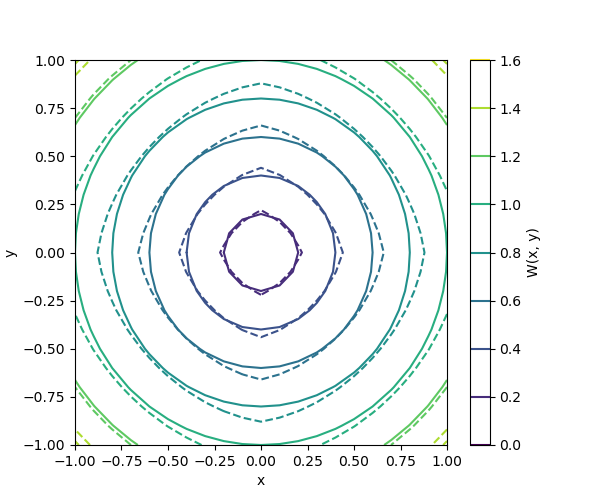

In [4]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False
contour = ax.contour(xs, ys, W_iterative, linestyles="dashed") # , label="Iterative"
ax.contour(xs, ys, W_exact) # , label="Exact"
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel("x")
ax.set_ylabel("y")
# ax.legend()
fig.colorbar(contour, label="W(x, y)");